In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
from prophet import Prophet
from sklearn.metrics import r2_score

In [5]:
plt.style.use("ggplot")

In [8]:
df0 = pd.read_csv("/content/sample_data/CONVENIENT_global_confirmed_cases.csv")
df1 = pd.read_csv("/content/sample_data/CONVENIENT_global_deaths.csv")

In [9]:
world = pd.DataFrame({"Country":[] ,"Cases":[]})
world["Country"] = df0.iloc[: ,1:].columns

cases = []
for i in world["Country"]:
    cases.append(pd.to_numeric(df0[i][1:]).sum())
world["Cases"] = cases

In [10]:
country_list = list(world["Country"].values)

idx = 0
for i in country_list:
    counter = 0
    for j in i:
        if j == ".":
            i = i[ :counter]
            country_list[idx] = i
        elif j == "(":
            i = i[ :counter-1]
            country_list[idx] = i
        else :
            counter += 1
    idx += 1

world["Country"] = country_list
world = world.groupby("Country")["Cases"].sum().reset_index()

In [11]:
world.head()

,Country,Cases
0,Afghanistan,209451.0
1,Albania,334457.0
2,Algeria,271496.0
3,Andorra,47890.0
4,Angola,105288.0


In [16]:
continent = pd.read_csv("/content/sample_data/continents2.csv")
continent["name"] = continent["name"].str.upper()

In [19]:
#Data Visualization
world["Cases Range"] = pd.cut(world["Cases"] ,[-150000,50000,200000,800000,1500000,15000000] ,
                              labels = ["U50K","50Kto200K","200Kto800K","800Kto1.5M","1.5M+"])
alpha = []

for i in world["Country"].str.upper().values:
    if i == "BRUNEI":
        i = "BRUNEI DARUSSALAM"
    elif i == "US":
        i = "UNITED STATES"

    if len(continent[continent["name"] == i]["alpha-3"].values) == 0:
        alpha.append(np.nan)
    else :
        alpha.append(continent[continent["name"] == i]["alpha-3"].values[0])

world["Alpha3"] = alpha

fig = px.choropleth(world.dropna() ,
                    locations="Alpha3",
                    color="Cases Range",
                    projection="mercator",
                    color_discrete_sequence=["blue","khaki","yellow","orange","red"])
fig.update_geos(fitbounds="locations" ,visible=False)
fig.update_layout(margin={"r":0 ,"t":0 ,"l":0 ,"b":0})
fig.show()

/tmp/ipython-input-2088351329.py:10: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



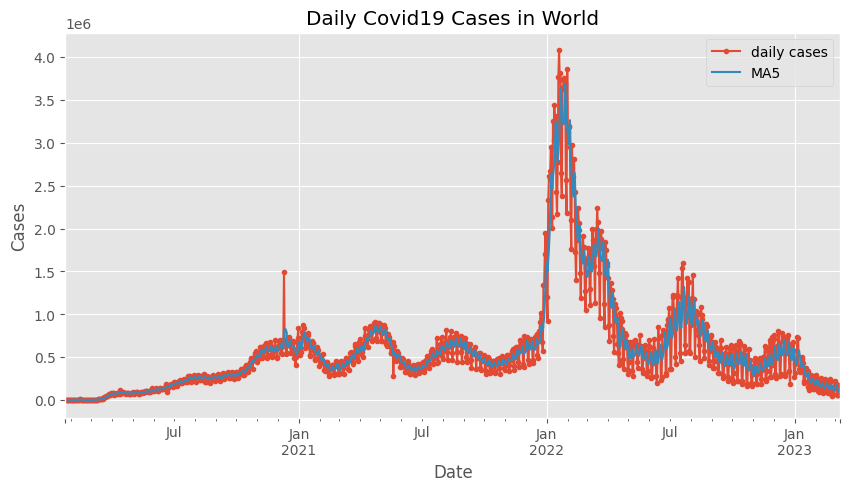

In [ ]:
count = []
for i in range(1 ,len(df0)):
    count.append(sum(pd.to_numeric(df0.iloc[i ,1:].values)))

df = pd.DataFrame()
df["Date"] = df0["Country/Region"][1:]
df["Cases"] = count

df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df = df.sort_index()

count = []
for i in range(1 ,len(df1)):
    count.append(sum(pd.to_numeric(df1.iloc[i ,1: ].values)))
df["Deaths"] = count

df.Cases.plot(title="Daily Covid19 Cases in World" ,marker="." ,figsize=(10 ,5),label="daily cases")
df.Cases.rolling(window=5).mean().plot(figsize=(10,5),label="MA5")
plt.ylabel("Cases")
plt.legend()
plt.show()

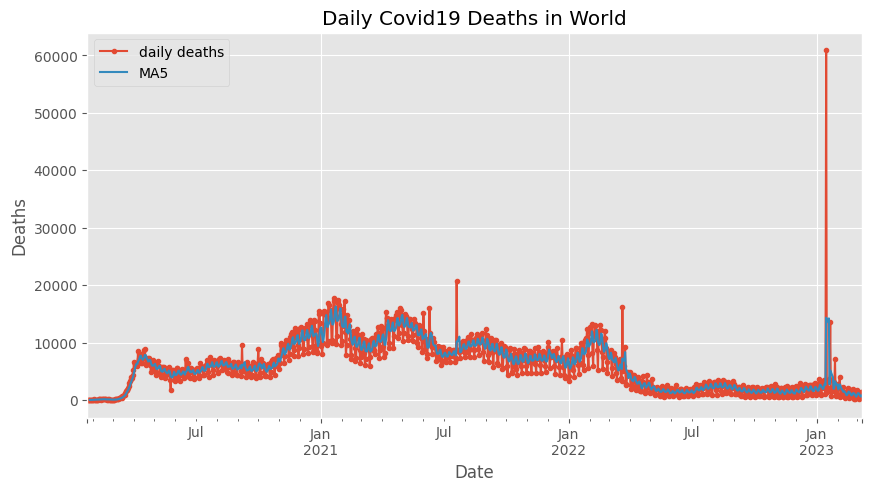

In [41]:
#Daily death cases of Covid-19:
df.Deaths.plot(title="Daily Covid19 Deaths in World" ,marker="." ,figsize=(10 ,5),label="daily deaths")
df.Deaths.rolling(window=5).mean().plot(figsize=(10 ,5) ,label="MA5")
plt.ylabel("Deaths")
plt.legend()
plt.show()

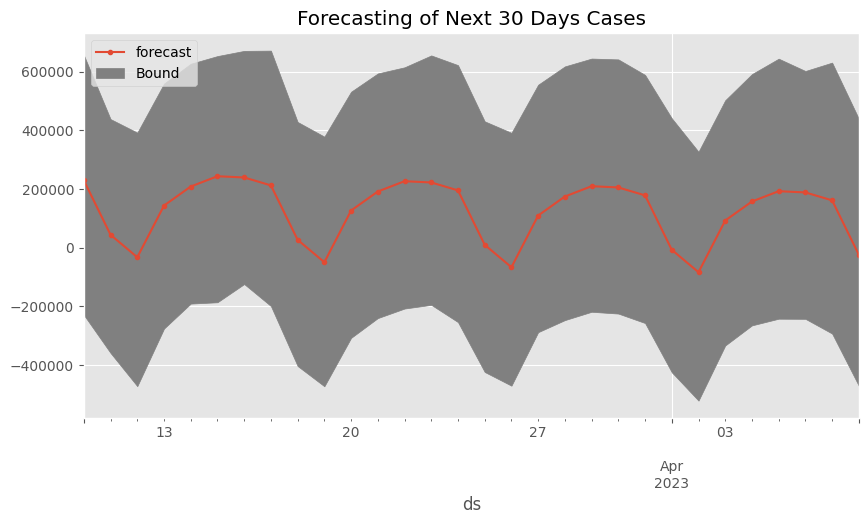

In [43]:
class Fbprophet(object):
    def fit(self,data):

        self.data  = data
        self.model = Prophet(weekly_seasonality=True,daily_seasonality=False,yearly_seasonality=False)
        self.model.fit(self.data)

    def forecast(self,periods,freq):

        self.future = self.model.make_future_dataframe(periods=periods,freq=freq)
        self.df_forecast = self.model.predict(self.future)

    def plot(self,xlabel="Years",ylabel="Values"):

        self.model.plot(self.df_forecast,xlabel=xlabel,ylabel=ylabel,figsize=(9,4))
        self.model.plot_components(self.df_forecast,figsize=(9,6))

    def R2(self):
        return r2_score(self.data.y, self.df_forecast.yhat[:len(df)])

df_fb  = pd.DataFrame({"ds":[],"y":[]})
df_fb["ds"] = pd.to_datetime(df.index)
df_fb["y"]  = df.iloc[:,0].values

model = Fbprophet()
model.fit(df_fb)
model.forecast(30,"D")
model.R2()

forecast = model.df_forecast[["ds","yhat_lower","yhat_upper","yhat"]].tail(30).reset_index().set_index("ds").drop("index",axis=1)
forecast["yhat"].plot(marker=".",figsize=(10,5))
plt.fill_between(x=forecast.index, y1=forecast["yhat_lower"], y2=forecast["yhat_upper"],color="gray")
plt.legend(["forecast","Bound"],loc="upper left")
plt.title("Forecasting of Next 30 Days Cases")
plt.show()